# Useful Functions

In [1]:
# Function to assess model and visualize output
def model_assessment(train, test, predictions, chart_title):
  # Set the size of the plot to 10 inches by 4 inches
  plt.figure(figsize = (10,4))
  # Plot the train, test, and forecast data
  plt.plot(train, label = 'Train')
  plt.plot(test, label = 'Test')
  plt.plot(predictions, label = "Forecast")
  # add title and legend to the plot
  plt.title(f"Train, Test and Predictions with {chart_title}")
  plt.legend()
  plt.show()

  # Calculating the MAE, RMSE, and MAPE
  mae = mean_absolute_error(test, predictions)
  rmse = mean_squared_error(test, predictions)
  mape = mean_absolute_percentage_error(test, predictions)

  # Print the calculated error metrics
  print(f"The MAE is {mae:.2f}")
  print(f"The RMSE is {rmse:.2f}")
  print(f"The MAPE is {100 * mape:.2f} %")

In [2]:
# Function to plot the future
def plot_future(y, forecast, title):
  # Set the size of the plot to 10 inches by 4 inches
  plt.figure(figsize = (10,4))
  # Plot the train and forecast data
  plt.plot(y, label = 'Train')
  plt.plot(forecast, label = "Forecast")
  # add title and legend to the plot
  plt.title(f"Train and Forecast with {title}")
  plt.legend()
  plt.show()

# Libraries and Data

In [69]:
# from google.colab import drive
# drive.mount('/content/drive')

In [70]:
# %cd /content/drive/MyDrive/Python - Time Series Forecasting/Time Series Analysis/ARIMA, SARIMA and SARIMAX

In [3]:
!pip install pmdarima

In [3]:
# Libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from pmdarima import auto_arima, ARIMA, model_selection
import numpy as np
from sklearn.model_selection import ParameterGrid

In [4]:
# Loading the daily revenue data and set the date as uindex
df = pd.read_csv("Amazon.csv",
                 index_col = "Date",
                 parse_dates = True,
                 dayfirst = True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200


In [5]:
df.shape

(5842, 6)

In [6]:
# Information about the df
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5842 entries, 1997-05-15 to 2020-07-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5842 non-null   float64
 1   High       5842 non-null   float64
 2   Low        5842 non-null   float64
 3   Close      5842 non-null   float64
 4   Adj Close  5842 non-null   float64
 5   Volume     5842 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 319.5 KB


There is no preprocessing that can happen here because the data is of type float and int

In [74]:
# Remove the comma in revenue and convert it as float
df['revenue'] = df['revenue'].str.replace(",", "").astype(float)

In [7]:
# Set the dataframe to have daily frequency, it will give a lot of null value
df_freq_d = df.asfreq("D")

We will consider the close as y value

In [8]:
# Change the time Series variable name
df_freq_d = df_freq_d.rename(columns = {'Close': 'y'})
df_freq_d.head()

,Open,High,Low,y,Adj Close,Volume
Date,,,,,,
1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000.0
1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000.0
1997-05-17,NaN,NaN,NaN,NaN,NaN,NaN
1997-05-18,NaN,NaN,NaN,NaN,NaN,NaN
1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800.0


In [9]:
df_freq_d.shape

(8479, 6)

Here after using the frequency of Day, it was having many NaN values because of the weekends days [Saturday, Sunday] and we find that the shape has increased from 5842 to 8479, so we will use the B day instead

In [10]:
df_freq_B = df.asfreq("B")

In [11]:
df_freq_B.shape

(6057, 6)

In [12]:
df_freq_B.isnull().sum()

Open         215
High         215
Low          215
Close        215
Adj Close    215
Volume       215
dtype: int64

In [13]:
df_freq_B.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000.0
1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000.0
1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800.0
1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200.0
1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200.0


The reason the size became 6057 and not 5842 was because many business days could be off due to official holidays and/or extraordinary event

In [14]:
# Here we see which days were added and at the same time were holiday and/or extraordinary event
df_original = pd.read_csv("Amazon.csv", index_col="Date", parse_dates=True, dayfirst=True)
df_full = df_original.asfreq("B")

missing_dates = df_full[df_full['Open'].isna()].index
print(missing_dates)
print(len(missing_dates))

DatetimeIndex(['1997-05-26', '1997-07-04', '1997-09-01', '1997-11-27',
               '1997-12-25', '1998-01-01', '1998-01-19', '1998-02-16',
               '1998-04-10', '1998-05-25',
               ...
               '2019-07-04', '2019-09-02', '2019-11-28', '2019-12-25',
               '2020-01-01', '2020-01-20', '2020-02-17', '2020-04-10',
               '2020-05-25', '2020-07-03'],
              dtype='datetime64[ns]', name='Date', length=215, freq=None)
215


A list of commonly used `.asfreq()` aliases:

Time-based frequencies:

- 'D': Calendar day frequency
- 'B': Business day frequency
- 'W': Weekly frequency
- 'W-MON', 'W-TUE', ..., 'W-SUN': Weekly frequency (anchored on a specific day)
- 'M': Month end frequency
- 'MS': Month start frequency
- 'Q': Quarter end frequency
- 'QS': Quarter start frequency
- 'A' or 'Y': Year end frequency
- 'BA' or 'BY': Business year end frequency
- 'AS' or 'YS': Year start frequency
- 'BAS' or 'BYS': Business year start frequency


Hourly, minutely, and secondly frequencies:

- 'H': Hourly frequency
- 'T' or 'min': Minutely frequency
- 'S': Secondly frequency


You can also use multiples, like:

- '2D': Every 2 days
- '4H': Every 4 hours
- '15T' or '15min': Every 15 minutes

# Exploratory Data Analysis

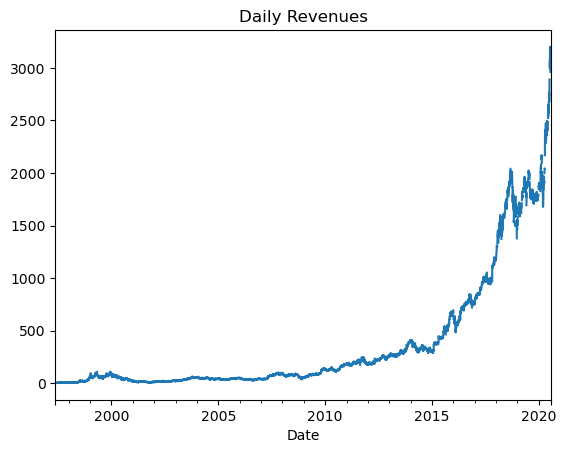

In [15]:
# Daily revenues line plot
df_freq_d['y'].plot(title = 'Daily Revenues')
plt.show()

In [16]:
df_freq_d.head()

,Open,High,Low,y,Adj Close,Volume
Date,,,,,,
1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000.0
1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000.0
1997-05-17,NaN,NaN,NaN,NaN,NaN,NaN
1997-05-18,NaN,NaN,NaN,NaN,NaN,NaN
1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800.0


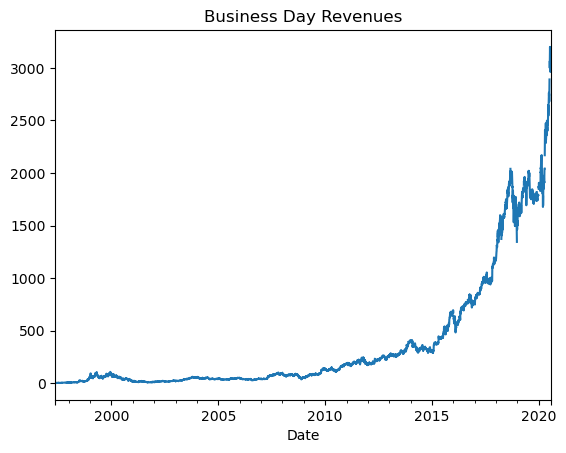

In [17]:
df_freq_B = df_freq_B.rename(columns = {'Close': 'y'})
df_freq_B['y'].plot(title = 'Business Day Revenues')
plt.show()

In [18]:
df_freq_B.head()

,Open,High,Low,y,Adj Close,Volume
Date,,,,,,
1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000.0
1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000.0
1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800.0
1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200.0
1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200.0


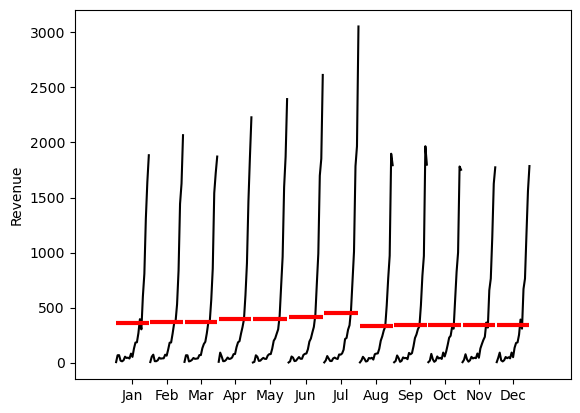

In [19]:
# month_plot() - To visualize the average value for each month across multiple years in a time series
# red lines - Represents the mean value for each month

# Plotting the monthly seasonality of revenue values
month_plot(df_freq_d['y'].resample('M').mean(),
           ylabel = 'Revenue')
plt.show()

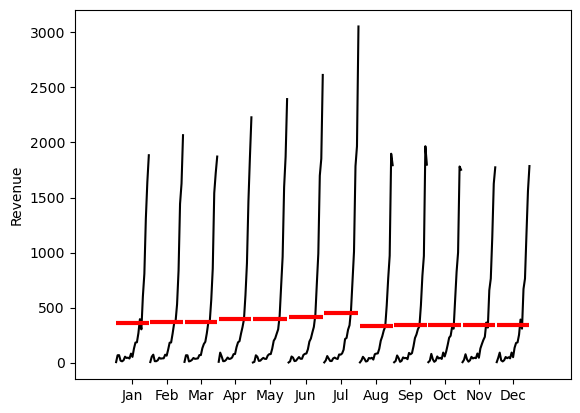

In [20]:
month_plot(df_freq_B['y'].resample('M').mean(),
           ylabel = 'Revenue')
plt.show()

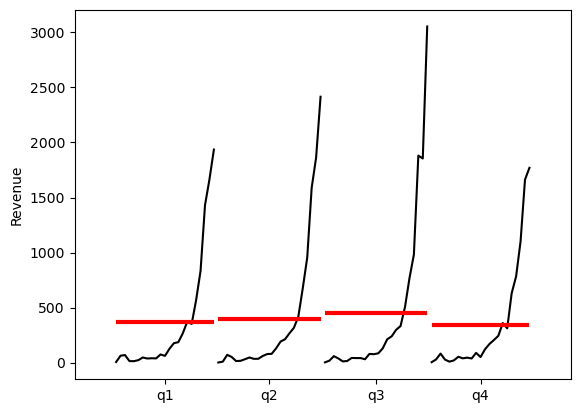

In [21]:
# quarter_plot() - To visualize seasonal patterns at a quarterly level.
# Q1 (january, february, march), Q2 (april, may, june), Q3 (july, august, september), Q4 (october, november, december)

# Plotting the quarterly seasonality of revenue values
# .resample('Q') - to convert the time series data into quarterly seasonality
quarter_plot(df_freq_d['y'].resample('Q').mean(),
           ylabel = 'Revenue')
plt.show()

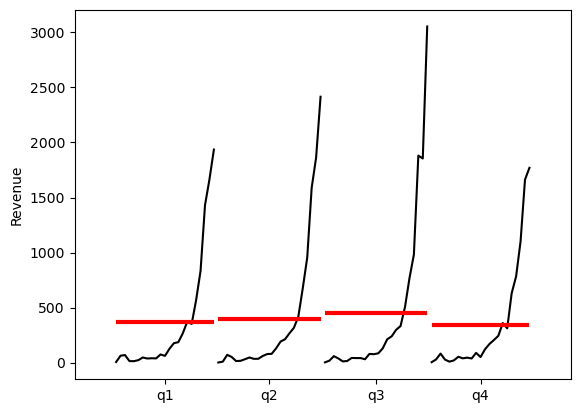

In [22]:
quarter_plot(df_freq_B['y'].resample('Q').mean(),
           ylabel = 'Revenue')
plt.show()

We can see there is no clear difference between the two, the reason any null values are automatically being ignored

`seasonal_decompose` - To decompose a time series into its constituent parts to better understand the underlying patterns.

components

- Trend: The overall direction of the series (increasing, decreasing, or stable).
- Seasonal: Repeating patterns at fixed intervals (e.g., daily, weekly, monthly).
- Residual: The remaining variation after removing trend and seasonal components.

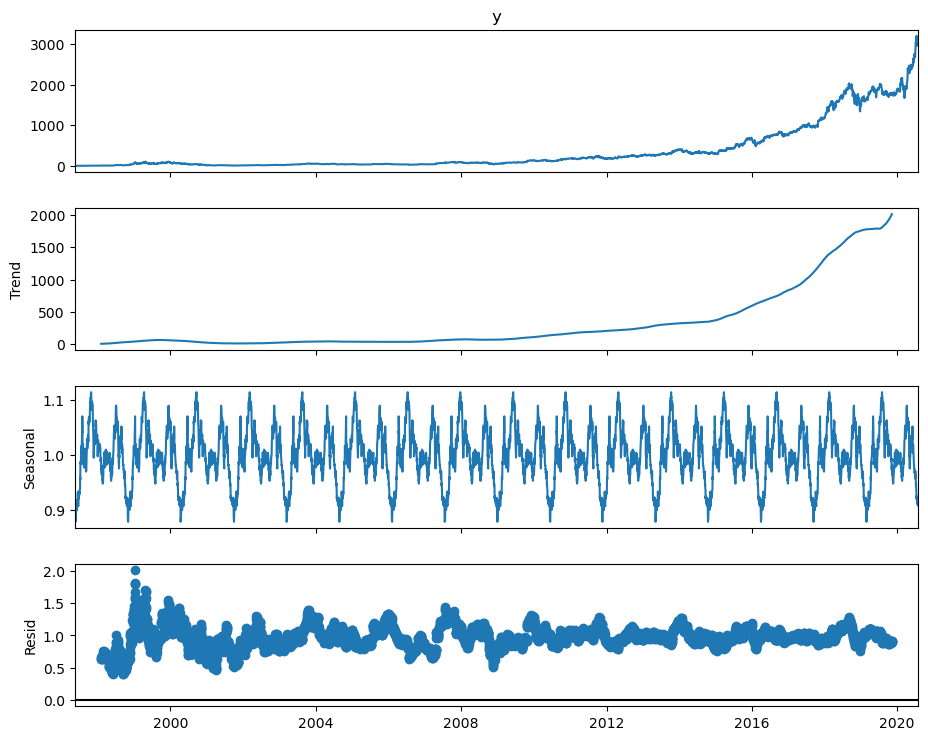

In [23]:
# Seasonal Decomposition Plots for Revenue Data
# Multiplicative model type, with daily seasonality (365 days)
df = df.rename(columns = {'Close': 'y'})
decomposition = seasonal_decompose(df['y'],
                                   model = 'mul',
                                   period = 365)
fig = decomposition.plot()
fig.set_size_inches(10,8)
plt.show()

Autocorrelation measures the correlation between a time series and a lagged version of itself.

Purpose: To identify patterns or repeating cycles in a time series dataset.

Interpretation:
- Values range from -1 to 1.
- 1 indicates perfect positive correlation.
- -1 indicates perfect negative correlation.
- 0 indicates no correlation.

ACF Plot:
- X-axis: Lag periods
- Y-axis: Correlation coefficient

Key Features:
- At lag 0, autocorrelation is always 1 (a series is perfectly correlated with itself).
- Significant spikes at certain lags indicate repeating patterns.


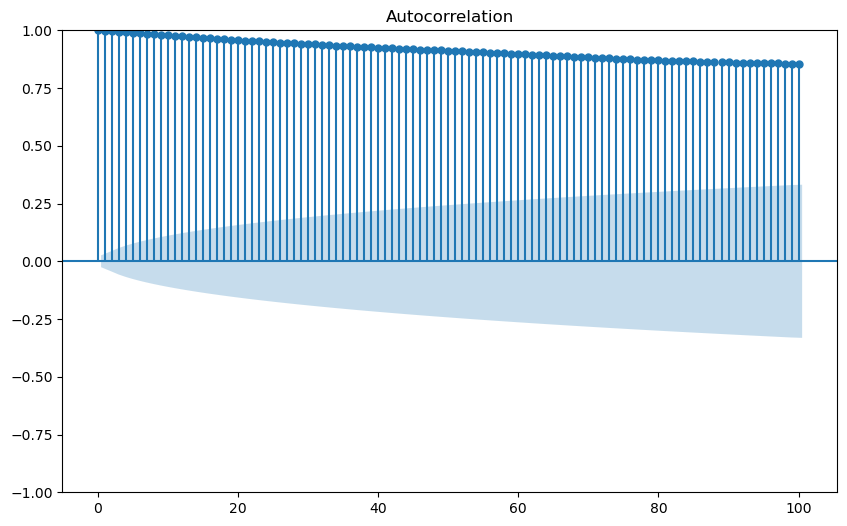

In [24]:
# Plot the autocorrelation (ACF) of revenue values
fig, ax = plt.subplots(figsize = (10,6))
plot_acf(df['y'], lags = 100, ax = ax)
plt.show()

PACF measures the correlation between a time series and its lag, after removing the effects of all shorter lags.

Purpose: To identify the direct relationship between an observation and its lag, without intermediate effects.

Main Difference between ACF and PACF:
- ACF: Measures overall correlation at each lag, including indirect effects.
- PACF: Measures direct correlation at each lag, excluding indirect effects.

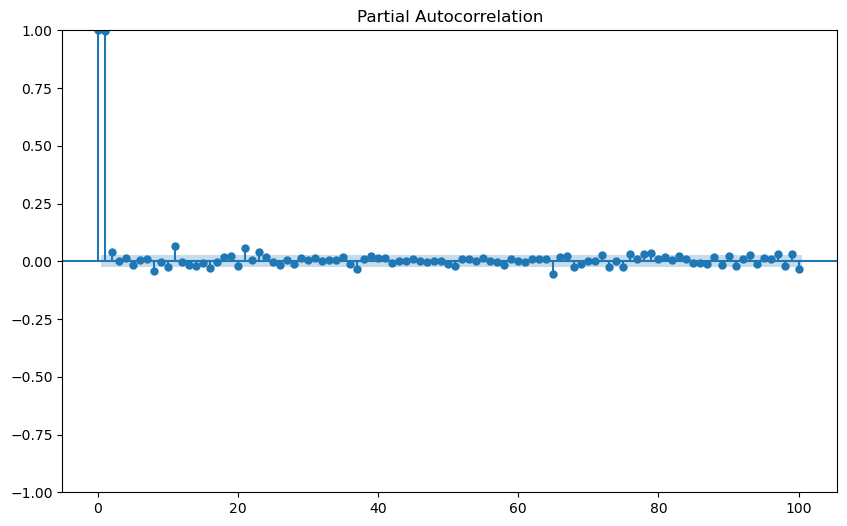

In [25]:
# Plot the partial autocorrelation (PACF) of revenue values
fig, ax = plt.subplots(figsize = (10,6))
plot_pacf(df['y'], lags = 100, ax = ax)
plt.show()

`.resample()` offset aliases:
- B = business day
- D = calendar day
- W = weekly
- M = month end
- BM = business month end
- MS = month start
- BMS = business month start
- Q = quarter end
- BQ = business quarter end
- QS = quarter start
- BQS = business quarter start
- A = year end
- BA = business year end
- AS = year start
- BAS = business year start
- h = hourly
- min = minutely
- s = secondly
- ms = milliseconds
- us = microseconds

# Stationarity

`adfuller` - used to perform the Augmented Dickey-Fuller test, which is a statistical test for testing the stationarity of a time series

 Stationarity implies that the statistical properties of the time series, such as mean and variance, do not change over time.

 The test evaluates a null hypothesis that the time series is non-stationary. If the p-value obtained from the test is less than a significance level (commonly 0.05), we reject the null hypothesis and conclude that the time series is stationary.

In [26]:
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test
# 'result' contains the test statistic and the p-value.
result = adfuller(df.y)
print('p-value: %f' % result[1])

# Interpreting the results
if result[1] < 0.05:
    print("Evidence suggests that the time series is stationary.")
else:
    print("Evidence suggests that the time series is not stationary.")


p-value: 1.000000
Evidence suggests that the time series is not stationary.


The reason is because it is highly non-stationary

In [27]:
# Compute the first difference of the 'y' column in DataFrame 'df' and assign it to a new column 'y_diff'.
# '.diff()' calculates the difference between consecutive elements along the specified axis (by default axis 0).
# 'dropna()' removes any rows with NaN values resulting from differencing.
df['y_diff'] = df.y.diff().dropna()
df['y_diff']

Date
1997-05-15           NaN
1997-05-16     -0.229167
1997-05-19     -0.020833
1997-05-20     -0.072917
1997-05-21     -0.208333
                 ...    
2020-07-27     46.300049
2020-07-28    -54.879883
2020-07-29     33.199951
2020-07-30     18.349854
2020-07-31    112.800049
Name: y_diff, Length: 5842, dtype: float64

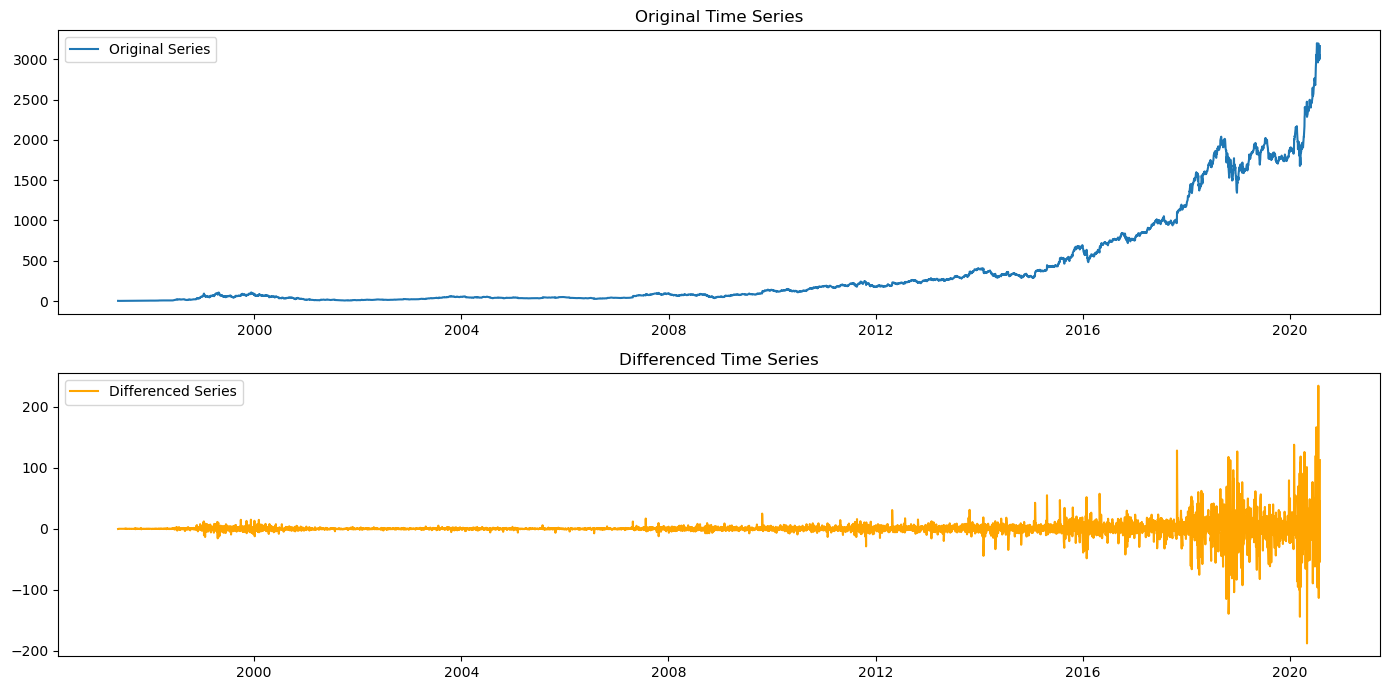

In [28]:
# Plotting the original and differenced series
# Set the size of the plot to 14 inches by 7 inches
plt.figure(figsize=(14, 7))

# Subplot for the original series
plt.subplot(2, 1, 1)  # 2 rows, 1 column, 1st subplot
plt.plot(df.y, label='Original Series')
plt.title('Original Time Series')
plt.legend()

# Subplot for the differenced series
plt.subplot(2, 1, 2)  # 2 rows, 1 column, 2nd subplot
plt.plot(df['y_diff'], label='Differenced Series', color='orange')
plt.title('Differenced Time Series')
plt.legend()

# Adjust layout to prevent overlapping of titles and labels
plt.tight_layout()
plt.show()

The biggest difference is at the last part of the data after 2018 when amazon value exceeded 1 Trillion $ 

In [29]:
# Perform ADF test without null values
# 'result' contains the test statistic and the p-value.
result = adfuller(df['y_diff'].dropna())
print('p-value: %f' % result[1])

# Interpreting the results
if result[1] < 0.05:
    print("Evidence suggests that the time series is stationary.")
else:
    print("Evidence suggests that the time series is not stationary.")


    

p-value: 0.000000
Evidence suggests that the time series is stationary.


The reason is because it is highly stationary

# ARIMA Model

We took 600 days for testing which are around 10% of the data

In [30]:
# Split the Data into training and test
test_days = 600 # Number of days to reserve for testing
train, test = df.iloc[:-test_days], df.iloc[-test_days:]
test

,Open,High,Low,y,Adj Close,Volume,y_diff
Date,,,,,,,
2018-03-15,1595.000000,1596.910034,1578.109985,1582.319946,1582.319946,4069700,-8.680054
2018-03-16,1583.449951,1589.439941,1567.500000,1571.680054,1571.680054,5425000,-10.639893
2018-03-19,1554.530029,1561.660034,1525.349976,1544.930054,1544.930054,6580800,-26.750000
2018-03-20,1550.339966,1587.000000,1545.410034,1586.510010,1586.510010,4581600,41.579956
2018-03-21,1586.449951,1590.000000,1563.170044,1581.859985,1581.859985,4750800,-4.650024
...,...,...,...,...,...,...,...
2020-07-27,3062.000000,3098.000000,3015.770020,3055.209961,3055.209961,4170500,46.300049
2020-07-28,3054.270020,3077.090088,2995.760010,3000.330078,3000.330078,3126700,-54.879883
2020-07-29,3030.989990,3039.159912,2996.770020,3033.530029,3033.530029,2974100,33.199951


In [31]:
# auto_arima() from pmdarima - used to automatically select the optimal parameters for an ARIMA model based on the provided time series data.
# 'seasonal=False' indicates that the model should not consider seasonal components.
model = auto_arima(train['y'],
                   seasonal = False)
model.summary()

C:\Users\marha\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\marha\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\marha\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\marha\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\marha\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5242
Model:               SARIMAX(5, 2, 0)   Log Likelihood              -17039.849
Date:                Fri, 27 Jun 2025   AIC                          34091.699
Time:                        01:38:34   BIC                          34131.083
Sample:                             0   HQIC                         34105.470
                               - 5242                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8139      0.005   -151.623      0.000      -0.824      -0.803
ar.L2         -0.6549      0.007    -97.438      0.000      -0.668      -0.642
ar.L3         -0.5318      0.007    -78.499      0.000      -0.545      -0.518
ar.L4         -0.4009      0.007    -55.568      0.000      -0.415      -0.387
ar.L5         -0.1899      0.005    -35.694      0.000      -0.200      -0.179
sigma2        39.0818      0.141    276.652      0.000      38.805      39.359
===================================================================================
Ljung-Box (L1) (Q):                   1.96   Jarque-Bera (JB):            766377.81
Prob(Q):                              0.16   Prob(JB):                         0.00
Heteroskedasticity (H):              17.94   Skew:                             1.71
Prob(H) (two-sided):                  0.00   Kurtosis:                        62.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
# Use the fitted ARIMA model to forecast future values.
# set the number of periods to forecast to the length of 'test'
predictions_arima = model.predict(n_periods = len(test))
predictions_arima

C:\Users\marha\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\marha\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\marha\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


5242    1598.686688
5243    1608.865770
5244    1620.239542
5245    1626.839813
5246    1630.791925
           ...     
5837    5877.727000
5838    5884.911673
5839    5892.096346
5840    5899.281019
5841    5906.465693
Length: 600, dtype: float64

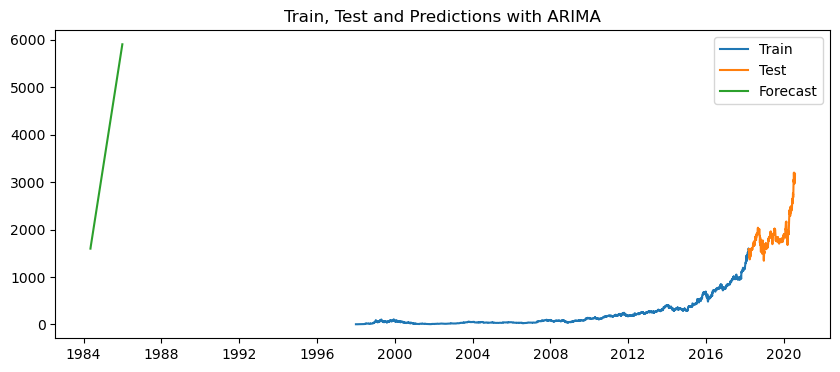

The MAE is 1868.10
The RMSE is 4570011.97
The MAPE is 97.07 %


In [33]:
# Model assessment
model_assessment(train['y']['1998':], test['y'], predictions_arima, "ARIMA")

The reason of this strange graph, that the index column was gone so matplotlib assigned it from 1984 because he did this calculation (1970 + 5000 days ≈ 1984) so to prevent it we do the following

In [34]:
predictions_arima = model.predict(n_periods=len(test))
predictions_arima.index = test.index
predictions_arima

C:\Users\marha\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\marha\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\marha\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Date
2018-03-15    1598.686688
2018-03-16    1608.865770
2018-03-19    1620.239542
2018-03-20    1626.839813
2018-03-21    1630.791925
                 ...     
2020-07-27    5877.727000
2020-07-28    5884.911673
2020-07-29    5892.096346
2020-07-30    5899.281019
2020-07-31    5906.465693
Length: 600, dtype: float64

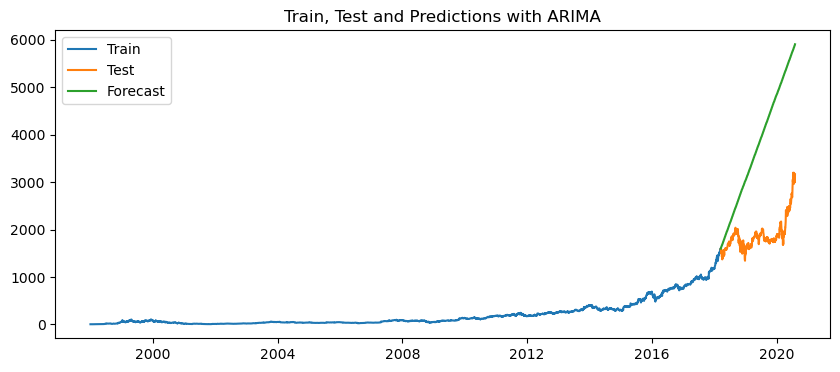

The MAE is 1868.10
The RMSE is 4570011.97
The MAPE is 97.07 %


In [35]:
model_assessment(train['y']['1998':], test['y'], predictions_arima, "ARIMA")

ARIMA has captured the upward trend 

In [36]:
df.head()

,Open,High,Low,y,Adj Close,Volume,y_diff
Date,,,,,,,
1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000,NaN
1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000,-0.229167
1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800,-0.020833
1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200,-0.072917
1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200,-0.208333


# SARIMA

In [37]:
# auto_arima() from pmdarima - used to automatically select the optimal parameters for an ARIMA model based on the provided time series data.
# m = The number of periods in each season.
model_sarima = auto_arima(train['y'],
                          m = 7)
model_sarima.summary()

C:\Users\marha\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\marha\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\marha\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\marha\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\marha\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 5242
Model:             SARIMAX(5, 2, 0)x(1, 0, [1], 7)   Log Likelihood              -17031.537
Date:                             Fri, 27 Jun 2025   AIC                          34079.073
Time:                                     01:40:55   BIC                          34131.586
Sample:                                          0   HQIC                         34097.435
                                            - 5242                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8127      0.005   -150.757      0.000      -0.823      -0.802
ar.L2         -0.6505      0.007    -94.535      0.000      -0.664      -0.637
ar.L3         -0.5322      0.007    -78.051      0.000      -0.546      -0.519
ar.L4         -0.4008      0.007    -55.289      0.000      -0.415      -0.387
ar.L5         -0.1914      0.006    -34.738      0.000      -0.202      -0.181
ar.S.L7       -0.6935      0.082     -8.473      0.000      -0.854      -0.533
ma.S.L7        0.6519      0.085      7.654      0.000       0.485       0.819
sigma2        38.9584      0.147    264.714      0.000      38.670      39.247
===================================================================================
Ljung-Box (L1) (Q):                   3.73   Jarque-Bera (JB):            748950.78
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):              17.89   Skew:                             1.70
Prob(H) (two-sided):                  0.00   Kurtosis:                        61.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [38]:
# Use the fitted SARIMA model to forecast future values.
# set the number of periods to forecast to the length of 'test'
predictions_sarima = model_sarima.predict(n_periods = len(test))
predictions_sarima.index = test.index
predictions_sarima

C:\Users\marha\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\marha\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\marha\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Date
2018-03-15    1598.285102
2018-03-16    1607.353389
2018-03-19    1617.906952
2018-03-20    1622.864280
2018-03-21    1624.569119
                 ...     
2020-07-27    5800.450533
2020-07-28    5807.509454
2020-07-29    5814.568374
2020-07-30    5821.627295
2020-07-31    5828.686216
Length: 600, dtype: float64

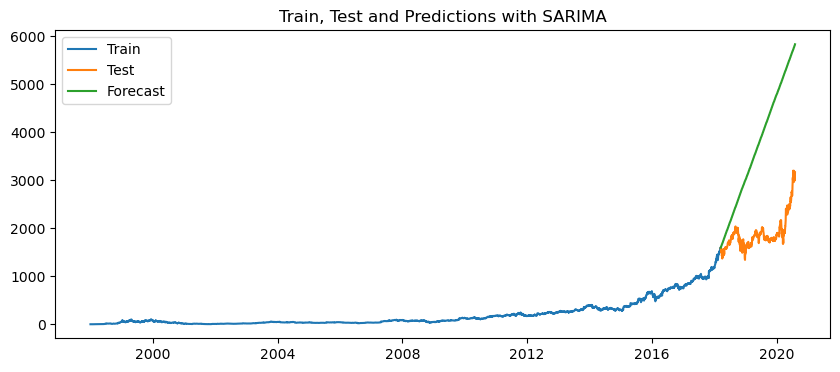

The MAE is 1827.98
The RMSE is 4378215.68
The MAPE is 95.01 %


In [39]:
# Model assessment
model_assessment(train['y']['1998':], test['y'], predictions_sarima, "SARIMA")

SARIMA has captured the upward trend

* The MAE is 7267306.02
* The RMSE is 12366038.29
* The MAPE is 24.15 %

- `MAE` - the average of the absolute differences between predicted and actual values.
- `RMSE` - the square root of the average of squared differences between prediction and actual observation.
It gives a relatively high weight to large errors, making it sensitive to outliers.
- `MAPE` - the size of the error in percentage terms. the average of the absolute percent errors of forecasts, which helps to understand the accuracy in terms of percentage.

# SARIMAX

In [27]:
# Remove '%' symbol from 'discount_rate' and 'coupon_rate' column and convert to float
df['discount_rate'] = df['discount_rate'].str.replace("%", "").astype(float)
df['coupon_rate'] = df['coupon_rate'].str.replace("%", "").astype(float)

# Print the information about the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1795 entries, 2018-01-01 to 2022-11-30
Freq: D
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   y              1795 non-null   float64
 1   discount_rate  1795 non-null   float64
 2   coupon_rate    1795 non-null   float64
 3   y_diff         1794 non-null   float64
dtypes: float64(4)
memory usage: 70.1 KB


In [40]:
# Split the Regressor Data into training and test
test_days = 600 # Number of days to reserve for testing
exog_train, exog_test = df.iloc[:-test_days,1:4], df.iloc[-test_days:,1:4]
exog_test.head()

,High,Low,y
Date,,,
2018-03-15,1596.910034,1578.109985,1582.319946
2018-03-16,1589.439941,1567.500000,1571.680054
2018-03-19,1561.660034,1525.349976,1544.930054
2018-03-20,1587.000000,1545.410034,1586.510010
2018-03-21,1590.000000,1563.170044,1581.859985


In [41]:
train['y']

Date
1997-05-15       1.958333
1997-05-16       1.729167
1997-05-19       1.708333
1997-05-20       1.635417
1997-05-21       1.427083
                 ...     
2018-03-08    1551.859985
2018-03-09    1578.890015
2018-03-12    1598.390015
2018-03-13    1588.180054
2018-03-14    1591.000000
Name: y, Length: 5242, dtype: float64

In [42]:
exog_train

,High,Low,y
Date,,,
1997-05-15,2.500000,1.927083,1.958333
1997-05-16,1.979167,1.708333,1.729167
1997-05-19,1.770833,1.625000,1.708333
1997-05-20,1.750000,1.635417,1.635417
1997-05-21,1.645833,1.375000,1.427083
...,...,...,...
2018-03-08,1554.880005,1545.250000,1551.859985
2018-03-09,1578.939941,1559.079956,1578.890015
2018-03-12,1605.329956,1586.699951,1598.390015


In [43]:
# auto_arima() from pmdarima - used to automatically select the optimal parameters for an ARIMA model based on the provided time series data.
# m = The number of periods in each season.
# X =  exogenous variables.
model_sarimax = auto_arima(train['y'],
                           m = 7,
                           X = exog_train
                           )
model_sarimax.summary()

C:\Users\marha\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\marha\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\marha\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\marha\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\marha\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5242
Model:               SARIMAX(0, 1, 0)   Log Likelihood               55512.492
Date:                Fri, 27 Jun 2025   AIC                        -111016.983
Time:                        01:42:50   BIC                        -110990.726
Sample:                             0   HQIC                       -111007.802
                               - 5242                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
High        2.551e-16   3.51e-24   7.26e+07      0.000    2.55e-16    2.55e-16
Low        -6.383e-17   2.56e-24  -2.49e+07      0.000   -6.38e-17   -6.38e-17
y              1.0000   3.85e-24    2.6e+23      0.000       1.000       1.000
sigma2          1e-10   2.74e-11      3.653      0.000    4.63e-11    1.54e-10
===================================================================================
Ljung-Box (L1) (Q):                  62.06   Jarque-Bera (JB):          68866347.33
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              23.71   Skew:                             5.00
Prob(H) (two-sided):                  0.00   Kurtosis:                       564.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

AR --> y1(t)=0.5 * y(t-1) + 0.9 y(t-2)  + ....      --> 9

S --> y2(t) = 0.5 y(t-365) + 0.1 y(t - 365*2) - ......  --> +2
  
X --> y3(t) bla bla bla   --> +1

final y(t) = AR y(t) + S y(t) + X y(t) = 12





 --------    MA --> y(t) = 0.1 e(t-1) + 0.2 * e(t-2)  --> -1


 final final y(t) = final y(t) + MA y(t) = 12 - 1 = 11


In [44]:
# Use the fitted SARIMAX model to forecast future values.
# set the number of periods to forecast to the length of 'test'
# X - representing the exogenous variables for forecasting
predictions_sarimax = model_sarimax.predict(n_periods = len(test),
                                            X = exog_test)
predictions_sarimax.index = test.index
predictions_sarimax

C:\Users\marha\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\marha\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\marha\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Date
2018-03-15    1582.319946
2018-03-16    1571.680054
2018-03-19    1544.930054
2018-03-20    1586.510010
2018-03-21    1581.859985
                 ...     
2020-07-27    3055.209961
2020-07-28    3000.330078
2020-07-29    3033.530029
2020-07-30    3051.879883
2020-07-31    3164.679932
Length: 600, dtype: float64

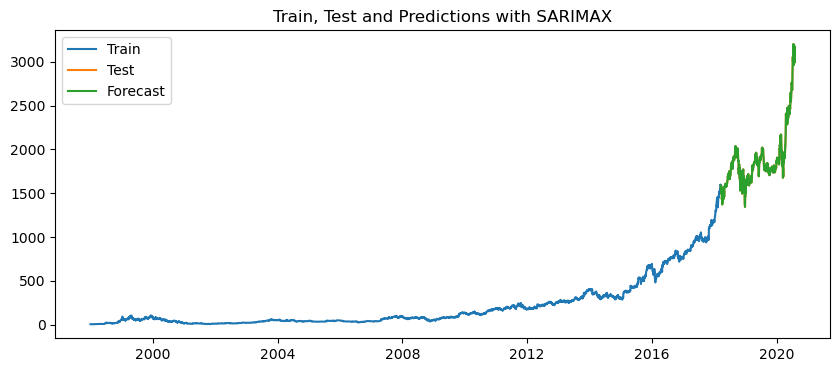

The MAE is 0.00
The RMSE is 0.00
The MAPE is 0.00 %


In [45]:
# Model assessment
model_assessment(train['y']['1998':], test['y'], predictions_sarimax, "SARIMAX")

We can see that SARIMAX was able to capture the pattern more accurately than ARIMA and SARIMA. While both were able to captured the general upward trend, they failed to reflect the finer details. SARIMAX performed better because it is able to handle exogenous variables, which help model the main time series more accurately.